## **Following are the steps employed to design and evaluate the model. Use these links to jump to each step**
- [1. EDA and splitting data](#1)
- [2. Preprocessing data](#2)
- [3. Handling class imbalance](#3)
- [4. Transfer learning with DenseNet121](#4)
    - [Model summary](#4-1)
- [5. Model evaluation](#5)
    - [Classification report](#5-1)
    - [Confusion matrix](#5-2)
    - [ROC AUC](#5-3)
- [6. Grad-cam evaluation](#6)

<a id='1'></a>
# **EDA and splitting data**

## Firstly, load all the libraries and modules 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator , load_img
from keras.models import Model

from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#WE WILL BE USING A LIST OF COMMMON STANDARD HELPER FUNCTIONS USED.
#CREDITS : DANIEL BOURKE, YOUTUBE LIVE ML INSTRUCTER CREATED A REPO CONTAINING THE HELPER FUNCTIONS:

# 1.LOAD AND PREPARE IMAGE
# 2.MAKE CONFUSION MATRIX
# 3.PLOT THE PREDICTED IMAGES
# 4.TENSORBOARD CALLBACK
# 5.PLOT LOSS CURVES
# 6.COMPARE HISTORIES
# 7.UNZIP DATA
# 8.WALK THROUGH DIRECTORY
# 9.CALCULATE RESULTS
# 10.GET TENSORFLOW VERSION
# 11. GET ROC CURVE

#https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/

### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_resultstf.__version__

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

<a id='1-1'></a>
### **Load images and metadata**

In [3]:
# load metadata
df_norm = pd.read_excel('TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [4]:
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [5]:
df_norm['Tuberculosis'] = float(0)
df_tb['Tuberculosis'] = float(1)
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [7]:
ds = "TB_Chest_Radiography_Database"
walk_through_dir(ds) # FROM HELPER FUNCTIONS

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')

print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 2 directories and 3 images in 'TB_Chest_Radiography_Database'.
There are 0 directories and 3500 images in 'TB_Chest_Radiography_Database\Normal'.
There are 0 directories and 700 images in 'TB_Chest_Radiography_Database\Tuberculosis'.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [8]:
def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal')
  os.makedirs(train_dir + '/Tuberculosis')
  os.makedirs(val_dir + '/Normal')
  os.makedirs(val_dir + '/Tuberculosis')
  os.makedirs(test_dir + '/Normal')
  os.makedirs(test_dir + '/Tuberculosis')
  os.makedirs(root_path + '/Images')

create_img_train_val_test_dirs('./')

In [9]:
IMAGE_DIR = os.path.join('./', 'Images')

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

<a id='1-2'></a>
### **Split data for train val and test dataset**
#### Partition as {train : Val : Test  == 80 : 10 : 10}
#### Equally split for both Normal and Tuberculosis

In [10]:
def split_data(source, training, val, testing, split_size_train=0.8, split_size_val=0.1):
    
    zero_length_files = [fn for fn in os.listdir(source) if os.path.getsize(os.path.join(source, fn)) == 0]
    
    for file_name in zero_length_files:
        print(f'{file_name} is zero length, so ignoring.')

    usable_files = [fn for fn in os.listdir(source) if fn not in zero_length_files]
    
    train_set = random.sample(usable_files, np.int64(split_size_train * len(usable_files)))
    remaining_files = [fn for fn in usable_files if fn not in train_set]
    val_set = random.sample(remaining_files, np.int64(split_size_val * len(usable_files)))
    test_set = [fn for fn in remaining_files if fn not in val_set]

    for fn in train_set:
        shutil.copy(os.path.join(source, fn), training)
    for fn in val_set:
        shutil.copy(os.path.join(source, fn), val)
    for fn in test_set:
        shutil.copy(os.path.join(source, fn), testing)

split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR, TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR, TESTING_TB_DIR)

In [11]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    
    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')
    
    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)
    
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [12]:
len(os.listdir(IMAGE_DIR))

4200

In [13]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res

In [14]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [15]:
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [16]:
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


<a id='1-3'></a>
### **Display sample images from training dataset**

In [17]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

<a id='2'></a>
# **Preprocessing data**

<a id='2-1'></a>
## **Build a train generator**
### **Preprocessing Norms followed here are:** 
1. **Normalize** the mean and standard deviation of **each data**
2. **Shuffle** the input after each epoch.
3. Set the image size to be **320px by 320px**
4. Apply some **augmentations (Rotation, Zoom, Width shift and Height shift)** based on position deviation which could possibly be slightly changed when radiographers x-ray patients
5. The generator converts single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels. (The pre-trained model requires three-channel inputs)

In [18]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("Getting Training  Generator...") 
    
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)
    
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    
   
    return train_generator

<a id='2-2'></a>
## **Build validation and test generators**
### **few things to note:**
1. We normalize validation data and incoming test data using the **statistics computed from the training set**
2. For reduce time consuming, we'll take a random sample of the dataset and calculate the sample mean and sample standard deviation. (Ideally, we should compute our sample mean and standard deviation using the entire training set)

In [19]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("Getting validation and Test Generators...")
    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))
    
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    image_generator.fit(data_sample)
    # if we want to calculate the mean and std on the entire training dataset
    # image_generator.fit(raw_train_generator)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return val_generator, test_generator

In [20]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

Getting Training  Generator...
Found 3360 validated image filenames.
Getting validation and Test Generators...
Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


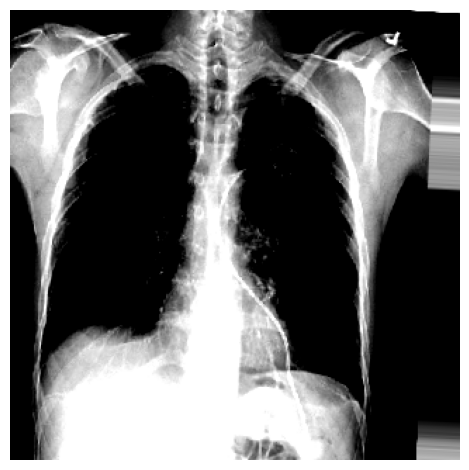

Image shape (320, 320, 3)


In [21]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

<a id='3'></a>
# **Handling class imbalance** 
### Fixed by Sample Weighting in Loss Function (weighting the contributions of positive and negative losses to be equal)
####  The code and ideas for handling class imbalance is inspired from  [here](https://www.kaggle.com/code/sanphats/microcalcification-weighting-loss-dnn)



In [22]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


In [23]:
#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

create positive/negative contributors
$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$
$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

In [24]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Final weight loss
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [25]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
    
        loss = 0.0        
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

<a id='4'></a>
# **Transfer learning with  BASE MODEL : DenseNet121**

In [26]:
## create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output

x = GlobalAveragePooling2D()(x)

output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)
model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=["accuracy","AUC"])

In [27]:
checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )

In [28]:
history = model.fit_generator(train_generator, 
                              validation_data=val_generator,
                              steps_per_epoch=100, 
                              validation_steps= 30,  
                              epochs = 3,
                              callbacks = [MC])

Epoch 1/3
100/100 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.8725 - auc: 0.9477
Epoch 1: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 643s 6s/step - loss: 0.0924 - accuracy: 0.8725 - auc: 0.9477 - val_loss: 1.9880 - val_accuracy: 0.8458 - val_auc: 0.5132
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9112 - auc: 0.9577
Epoch 2: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 639s 6s/step - loss: 0.0764 - accuracy: 0.9112 - auc: 0.9577 - val_loss: 1.0834 - val_accuracy: 0.8875 - val_auc: 0.7368
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9075 - auc: 0.9387
Epoch 3: saving model to ./training_1\cp.ckpt
100/100 [==============================] - 642s 6s/step - loss: 0.0946 - accuracy: 0.9075 - auc: 0.9387 - val_loss: 1.2539 - val_accuracy: 0.8708 - val_auc: 0.6579


In [29]:
model = Model(inputs=base_model.input, outputs = output)
model.load_weights(checkpoint_path)

<a id='5'></a>
# **Model evaluation**
#### Information and codes for model evaluation are inspired from here [AI in Medical diagnosis course](https://www.coursera.org/learn/ai-for-medical-diagnosis)


In [30]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


random.seed(a=None, version=2)
set_verbosity(INFO)

<a id='5-1'></a>
## **Classification report**

In [31]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
y_pred = np.where(predicted_vals >= 0.5,1 ,0)
y_pred = y_pred.flatten()

In [32]:
y_test = test_df['Tuberculosis']
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       350
         1.0       1.00      0.09      0.16        70

    accuracy                           0.85       420
   macro avg       0.92      0.54      0.54       420
weighted avg       0.87      0.85      0.79       420

Accuracy of the Model: 84.76190476190476 %


In [33]:
y_labels = ['Normal', 'Tuberculosis']
predictions = [y_labels[k] for k in y_pred]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions})
results.to_csv("predictions.csv",index=False)

<a id='5-2'></a>
## **Confusion matrix**

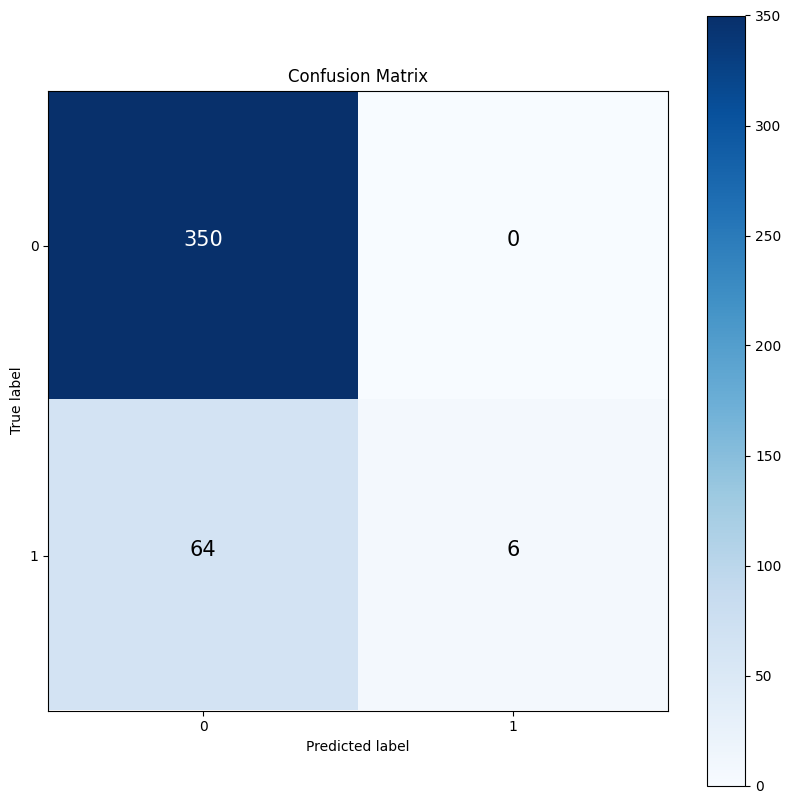

In [34]:
make_confusion_matrix(y_test, y_pred)

<a id='5-3'></a>
## **ROC AUC**

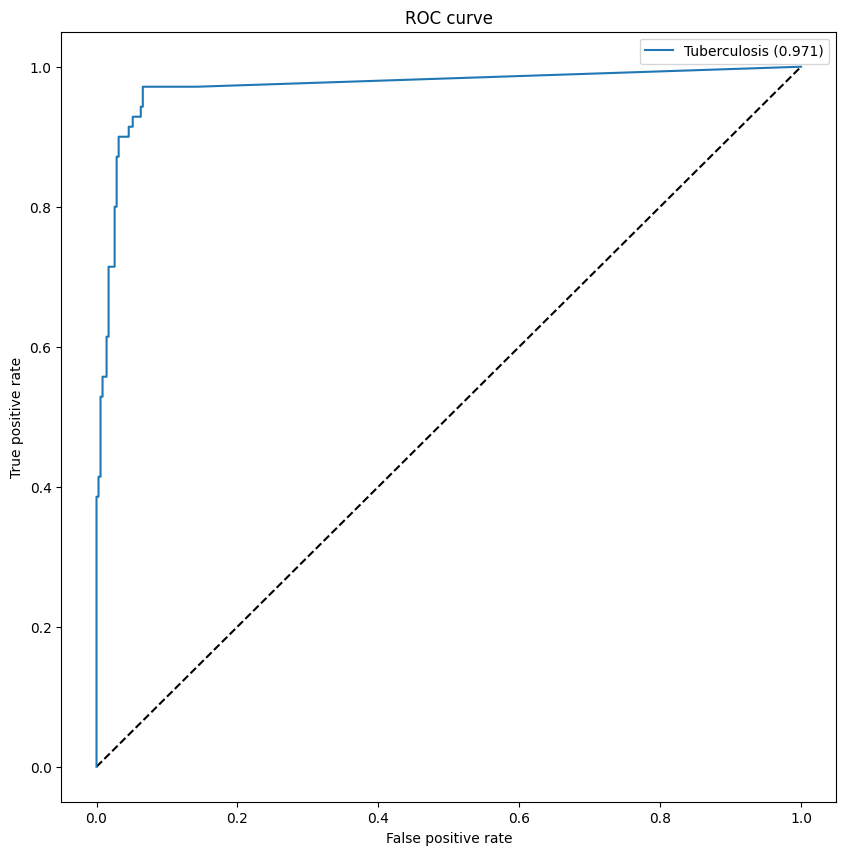

In [35]:
labels = ['Tuberculosis']
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

<a id='6'></a>
# **Grad-cam evaluation**

#### Codes are inspired by [stackoverflow](https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network)
#### Information on Gradient-weighted Class Activation Mapping (Grad-CAM)  technique used for image-DL feature extractiom can be found here [Cornell University](https://arxiv.org/abs/1610.02391) 

In [36]:
# Normalization using batch statistics
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(50)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
    return x


In [37]:
#THE FOLLOWING CODE SNIPPET IS INSPIRED FROM: 
#(https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network)
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [38]:
# Sample 50 images for Batch normalization
# Assuming test_df is your DataFrame and 'Image' is the column containing image filenames
# If test_df is not already imported, you need to import it or create it from your data source

shuffled_test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
imgs_path = []
for fn in shuffled_test_df['Image'][:50]:
    full_path = IMAGE_DIR + '/' + fn
    imgs_path.append(full_path)


'''imgs_path = []
for fn in test_df['Image'][:100]:
    full_path = IMAGE_DIR + '/' + fn
    imgs_path.append(full_path)
'''

"imgs_path = []\nfor fn in test_df['Image'][:100]:\n    full_path = IMAGE_DIR + '/' + fn\n    imgs_path.append(full_path)\n"

In [39]:
# Normalize with mean and std of batchs
test = [load_image(i, IMAGE_DIR, test_df ) for i in imgs_path]

In [40]:
test = np.array(test)
print(test.shape)

(50, 320, 320, 3)


In [46]:
# Find the sample image that is predicted as Tuberculosis 
preds = model.predict(test)
preds_ = np.where(preds > 0.5,1,0)
pos_pred = np.where(preds_.flatten() == 1)
n = pos_pred[0][0]
n

2/2 [==============================] - 6s 2s/step


38

In [47]:
# Now we know which images were predicted as Tuberculosis from preds_
# create img_test which is predicted Tuberculosis
img_test = np.expand_dims(test[n], axis = 0)
preds = model.predict(img_test) 
i = np.where(preds > 0.5,1,0)

# Verify if prediction == 1
i.flatten()

1/1 [==============================] - 0s 299ms/step


array([1])

In [48]:
img_path = imgs_path[n]

In [49]:
icam = GradCAM(model, i, 'conv5_block16_1_conv') 
heatmap = icam.compute_heatmap(img_test)
heatmap = cv2.resize(heatmap, (320, 320))

image = cv2.imread(img_path)
image = cv2.resize(image, (320, 320))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(320, 320) (320, 320, 3)


<a id='6-1'></a>
## **This is an demonstration of Grad-cam overlay on Tuberculosis**

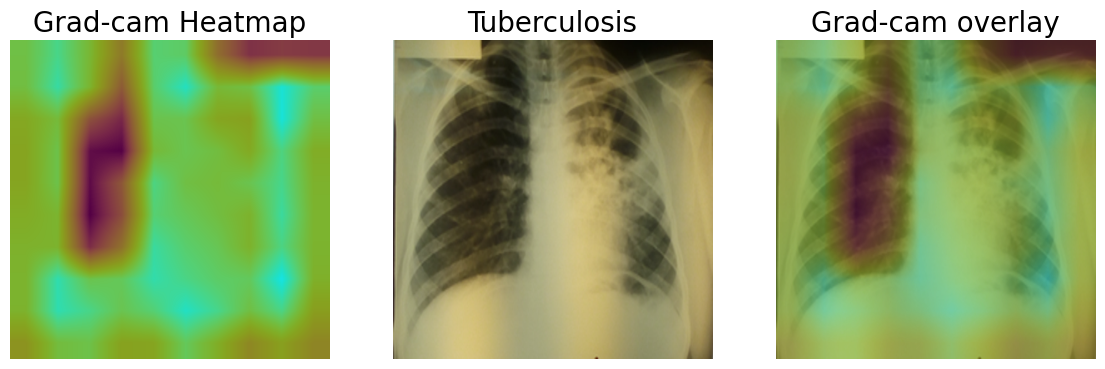

In [50]:
fig, ax = plt.subplots(1, 3, figsize = (14,14))

ax[0].imshow(heatmap)
ax[0].axis('Off')
ax[0].set_title('Grad-cam Heatmap', fontsize = 20)
ax[1].imshow(image)
ax[1].axis('Off')
ax[1].set_title('Tuberculosis', fontsize = 20)
ax[2].imshow(output)
ax[2].axis('Off')
ax[2].set_title('Grad-cam overlay', fontsize = 20)
fig.show()